In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import *
import seaborn as sns
from matplotlib import rcParams
import matplotlib as mpl
import datetime as dt
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.label_propagation import label_propagation_communities
from networkx.algorithms.community.label_propagation import asyn_lpa_communities
# import mplleaflet
from itertools import islice
import itertools
from random import random
from community import community_louvain
from collections import Counter
import matplotlib
import matplotlib.colors as mcolors

### Out of all the communities formed for the 12 time frames, the ones with observable patterns are studied in detail: 
#### We choose Weekday Morning Slot (Monday - 0800:1200) & Weekend Evening Slot ( Sunday - 2000:2400) 

# Weekday Morning Slot (Monday) 08:00 - 12:00

In [2]:
time3_wk = pd.read_csv('Clean_data_files_for_Community/time3_wk.csv')

In [3]:
trip3_wk=time3_wk.groupby(['start_station_name','end_station_name'])['tripduration'].count().reset_index()
trip3_wk.columns=['start_station_name','end_station_name','trips']

In [4]:
trip3_wk_latlong_start=time3_wk.groupby(['start_station_name', 'start_station_latitude', 'start_station_longitude'])['bikeid'].count().reset_index()
trip3_wk_latlong_start.columns=['station_name','latitude', 'longitude','trips']

In [5]:
trip3_wk_latlong_end=time3_wk.groupby(['end_station_name', 'end_station_latitude', 'end_station_longitude'])['bikeid'].count().reset_index()
trip3_wk_latlong_end.columns=['station_name','latitude', 'longitude','trips']

In [6]:
trip_wk_latlong = pd.concat([trip3_wk_latlong_start, trip3_wk_latlong_end], axis=0)

In [7]:
G=nx.from_pandas_edgelist(trip3_wk, source='start_station_name', target='end_station_name',edge_attr='trips')

weights = [G[u][v]['trips'] for u,v in G.edges()]
myInt = 200
weights[:] = [x / myInt for x in weights]

trips = [G[u][v]['trips'] for u,v in G.edges()]
trips=[float(i) for i in trips]
# plt.figure(3,figsize=(9,9))
# nx.draw(G, with_labels=False, width=weights, font_size=7, node_size=60)
# plt.show()

In [8]:
gn_communities = greedy_modularity_communities(G)

In [9]:
gn_dict_communities = {}

for i, c in enumerate(gn_communities):
    print ("Community {}".format(i))
    for node in c:
        gn_dict_communities[node] = i+1
        
for node in G:
    if node not in gn_dict_communities.keys():
        gn_dict_communities[node] = -1

Community 0
Community 1
Community 2
Community 3
Community 4
Community 5


In [10]:
gn_df=pd.DataFrame(gn_dict_communities.items())
gn_df.columns = ['station_name','Community']
gn_df.head()

,station_name,Community
0,Lefferts Pl & Franklin Ave,1
1,Douglass St & 4 Ave,1
2,Van Brunt St & Wolcott St,1
3,Fulton St & Waverly Ave,1
4,Kosciuszko St & Nostrand Ave,1


In [11]:
trip3_wk=pd.merge(trip3_wk,gn_df,left_on='start_station_name', right_on='station_name')
trip3_wk=pd.merge(trip3_wk,gn_df,left_on='end_station_name', right_on='station_name')
trip3_wk.head()
trip3_wk=trip3_wk.drop(['station_name_x','station_name_y'], axis=1)
trip3_wk.columns=['start_station_name','end_station_name','trips','start_community','end_community']
trip3_wk.head()

,start_station_name,end_station_name,trips,start_community,end_community
0,1 Ave & E 110 St,2 Ave & E 104 St,1,2,2
1,5 Ave & E 126 St,2 Ave & E 104 St,1,2,2
2,E 128 St & Madison Ave,2 Ave & E 104 St,1,2,2
3,Lenox Ave & W 111 St,2 Ave & E 104 St,1,2,2
4,1 Ave & E 110 St,2 Ave & E 96 St,1,2,2


In [12]:
trip3_wk_community1 = trip3_wk[trip3_wk['start_community']==1]
trip3_wk_community2 = trip3_wk[trip3_wk['start_community']==2]
trip3_wk_community3 = trip3_wk[trip3_wk['start_community']==3]

### Subset the trips data based on individual communities - Community 1

In [13]:
G_1=nx.from_pandas_edgelist(trip3_wk_community1, source='start_station_name', target='end_station_name',edge_attr='trips')

weights = [G_1[u][v]['trips'] for u,v in G_1.edges()]
myInt = 200
weights[:] = [x / myInt for x in weights]

trips = [G_1[u][v]['trips'] for u,v in G_1.edges()]
trips=[float(i) for i in trips]

### Centrality  for Comm 1

In [14]:
# unweighted
# closeness = nx.closeness_centrality(G)
# betweenness = nx.betweenness_centrality(G)
# eigenvector = nx.eigenvector_centrality(G)


degree = nx.degree_centrality(G_1)
closeness_w = nx.closeness_centrality(G_1, distance = 'trips')
betweenness_w = nx.betweenness_centrality(G_1, weight = 'trips')
eigenvector_w = nx.eigenvector_centrality(G_1, weight = 'trips')
pagerank=nx.pagerank(G_1)


# print out various centrality measures
print('\t\t\t\tDeg\tClo\tBet\tEig\tPR')
for n in G_1.nodes():
    print('%s\t\t\t%.3f\t%.3f\t%.3f\t%.3f' % (degree[n], closeness_w[n], betweenness_w[n], eigenvector_w[n], 
                                                     pagerank[n]))

				Deg	Clo	Bet	Eig	PR
0.02717391304347826			0.303	0.013	0.057	0.004
0.0018115942028985507			0.232	0.000	0.003	0.000
0.02717391304347826			0.302	0.010	0.026	0.004
0.007246376811594203			0.292	0.002	0.013	0.001
0.08152173913043478			0.342	0.073	0.114	0.012
0.028985507246376812			0.328	0.016	0.055	0.004
0.07608695652173914			0.329	0.059	0.060	0.011
0.04528985507246377			0.333	0.044	0.055	0.006
0.0018115942028985507			0.250	0.000	0.003	0.000
0.012681159420289856			0.278	0.006	0.014	0.002
0.0018115942028985507			0.218	0.000	0.001	0.001
0.03985507246376812			0.311	0.017	0.111	0.005
0.0036231884057971015			0.268	0.001	0.008	0.001
0.041666666666666664			0.321	0.043	0.053	0.006
0.0018115942028985507			0.248	0.000	0.003	0.000
0.036231884057971016			0.327	0.024	0.087	0.004
0.0018115942028985507			0.246	0.000	0.004	0.000
0.012681159420289856			0.241	0.003	0.001	0.002
0.0036231884057971015			0.259	0.003	0.009	0.001
0.050724637681159424			0.326	0.022	0.184	0.006
0.018115942028985508			0.267	0.027	0

In [15]:
# Top 5 nodes with the largest values of degree centrality in descending order
dict(Counter(degree).most_common(5))


{'Forsyth St & Canal St': 0.08152173913043478,
 'Fulton St & Adams St': 0.08152173913043478,
 'S 5 Pl & S 5 St': 0.07608695652173914,
 'Hanson Pl & Ashland Pl': 0.07608695652173914,
 'Rivington St & Chrystie St': 0.07246376811594203}

In [16]:
 #Top 5 nodes with the largest values of closeness centrality in descending order
dict(Counter(closeness_w).most_common(5))

{'Fulton St & Adams St': 0.3607843137254902,
 'Hanson Pl & Ashland Pl': 0.35430038510911427,
 'Jay St & York St': 0.34892541087231355,
 'Rivington St & Chrystie St': 0.3473882945248584,
 'Fulton St & Waverly Ave': 0.34435433562071116}

In [17]:
 #Top 5 nodes with the largest values of eigenvector centrality in descending order
dict(Counter(eigenvector_w).most_common(5))

{'Fulton St & Adams St': 0.2314530520580491,
 'Hanson Pl & Ashland Pl': 0.21058371475332124,
 'Bond St & Fulton St': 0.19202552479616652,
 'Willoughby St & Fleet St': 0.18368979787534864,
 'Bergen St & Smith St': 0.16930204982172373}

In [18]:
 #Top 5 nodes with the largest values of betweenness centrality in descending order
dict(Counter(betweenness_w).most_common(5))

{'Rivington St & Chrystie St': 0.08849829755179256,
 'Forsyth St & Canal St': 0.07327002573046644,
 'Kent Ave & N 7 St': 0.06744322190384835,
 'Fulton St & Adams St': 0.06541825468478825,
 'S 5 Pl & S 5 St': 0.05882201200715599}

In [19]:
 #Top 5 nodes with the largest values of pagerank centrality in descending order
dict(Counter(pagerank).most_common(5))

{'Forsyth St & Canal St': 0.011773527551643417,
 'Rivington St & Chrystie St': 0.01173562124444409,
 'S 5 Pl & S 5 St': 0.010692697407840446,
 'Fulton St & Adams St': 0.008851091622089953,
 'Hanson Pl & Ashland Pl': 0.008416385985363503}

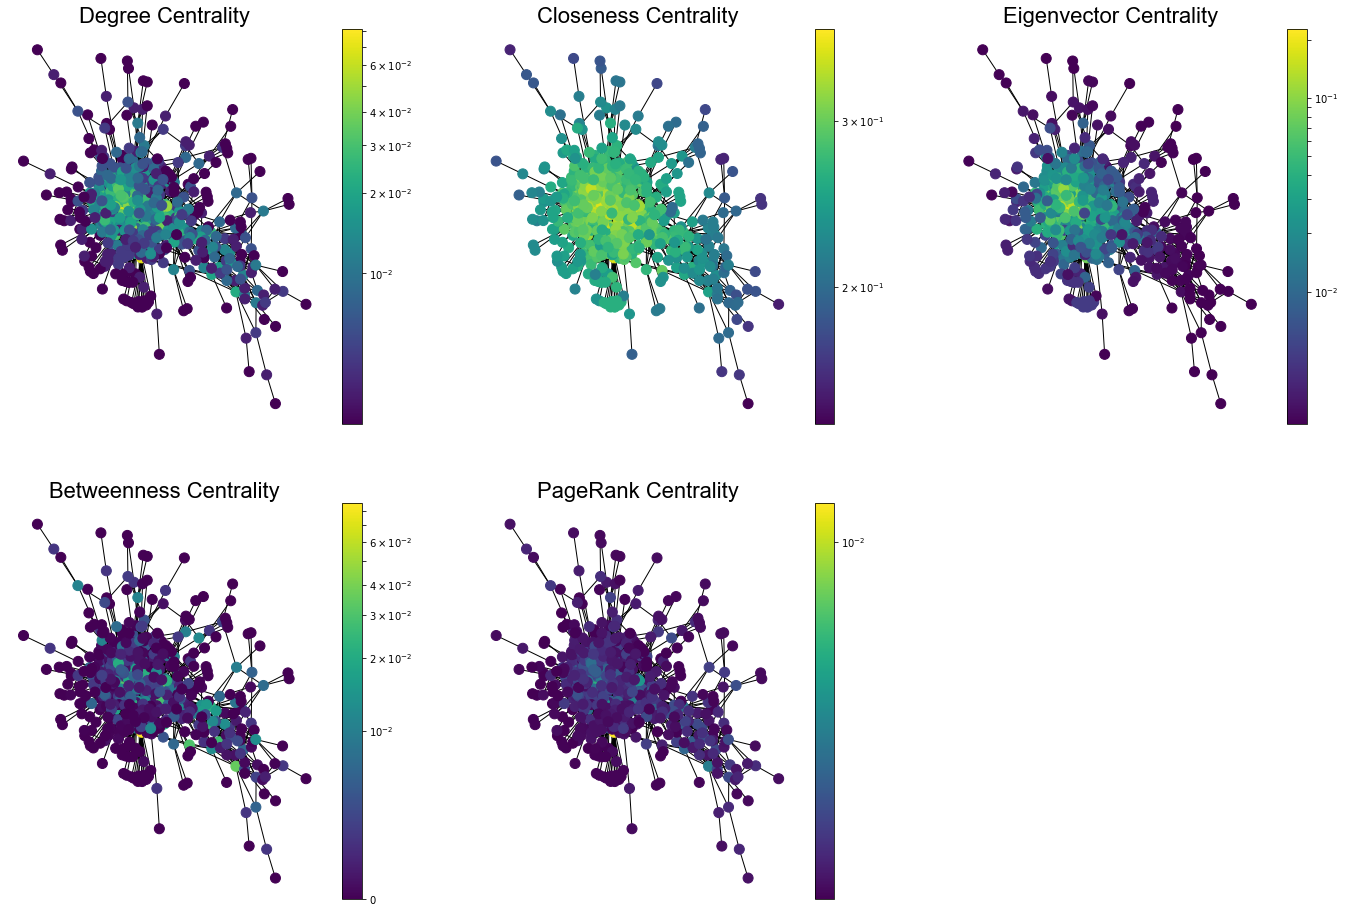

In [20]:
# Function to plot the graphs for each centrality metric
pos = nx.spring_layout(G_1)
matplotlib.rcParams['figure.figsize']= [24, 16]
def draw(G_1, pos, lista, listb, measure_name):
    nodes=nx.draw_networkx_nodes(G_1, pos, node_size=100, cmap=plt.cm.viridis,node_color=lista,nodelist=listb)
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    edges=nx.draw_networkx_edges(G_1, pos)
    plt.title(measure_name, fontsize=22, fontname='Arial')
    plt.colorbar(nodes)
    plt.axis('off')

plt.subplot(2,3,1)
list_pos_values = []
for i in nx.degree_centrality(G_1).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.degree_centrality(G_1).keys():
    list_pos_keys.append(i)
draw(G_1, pos, list_pos_values, list_pos_keys, 'Degree Centrality')

plt.subplot(2,3,2)
list_pos_values=[]
for i in nx.closeness_centrality(G_1).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.closeness_centrality(G_1).keys():
    list_pos_keys.append(i)
draw(G_1, pos, list_pos_values, list_pos_keys, 'Closeness Centrality')

plt.subplot(2,3,3)
list_pos_values=[]
for i in nx.eigenvector_centrality(G_1).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_1).keys():
    list_pos_keys.append(i)
draw(G_1, pos, list_pos_values, list_pos_keys, 'Eigenvector Centrality')

plt.subplot(2,3,4)
list_pos_values=[]
for i in nx.betweenness_centrality(G_1).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_1).keys():
    list_pos_keys.append(i)
draw(G_1, pos, list_pos_values, list_pos_keys, 'Betweenness Centrality')

plt.subplot(2,3,5)
list_pos_values=[]
for i in nx.pagerank(G_1).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_1).keys():
    list_pos_keys.append(i)
draw(G_1, pos, list_pos_values, list_pos_keys, 'PageRank Centrality')

### Subset the trips data based on individual communities - Community 2

In [21]:
G_2=nx.from_pandas_edgelist(trip3_wk_community2, source='start_station_name', target='end_station_name',edge_attr='trips')

weights = [G_2[u][v]['trips'] for u,v in G_2.edges()]
myInt = 200
weights[:] = [x / myInt for x in weights]

trips = [G_2[u][v]['trips'] for u,v in G_2.edges()]
trips=[float(i) for i in trips]

### Centrality for Comm 2

In [22]:
degree = nx.degree_centrality(G_2)
closeness_w = nx.closeness_centrality(G_2, distance = 'trips')
betweenness_w = nx.betweenness_centrality(G_2, weight = 'trips')
eigenvector_w = nx.eigenvector_centrality(G_2, weight = 'trips')
pagerank=nx.pagerank(G_2)


# print out various centrality measures
print('\t\t\t\tDeg\tClo\tBet\tEig\tPR')
for n in G_2.nodes():
    print('%s\t\t\t\t%.3f\t%.3f\t%.3f\t%.3f' % (degree[n], closeness_w[n], betweenness_w[n], eigenvector_w[n], 
                                                     pagerank[n]))

				Deg	Clo	Bet	Eig	PR
0.0297029702970297				0.345	0.003	0.001	0.002
0.03712871287128713				0.377	0.007	0.004	0.002
0.017326732673267328				0.336	0.001	0.001	0.001
0.017326732673267328				0.305	0.002	0.000	0.002
0.054455445544554455				0.385	0.007	0.010	0.003
0.04207920792079208				0.398	0.009	0.008	0.003
0.027227722772277228				0.373	0.001	0.004	0.002
0.007425742574257425				0.304	0.000	0.000	0.001
0.027227722772277228				0.385	0.002	0.007	0.002
0.024752475247524754				0.370	0.001	0.004	0.001
0.027227722772277228				0.354	0.002	0.003	0.002
0.0049504950495049506				0.299	0.000	0.000	0.001
0.04702970297029703				0.408	0.007	0.009	0.003
0.04455445544554455				0.394	0.010	0.005	0.003
0.04702970297029703				0.398	0.005	0.019	0.003
0.0297029702970297				0.378	0.003	0.006	0.002
0.04455445544554455				0.411	0.006	0.008	0.002
0.04702970297029703				0.413	0.003	0.012	0.002
0.007425742574257425				0.310	0.000	0.000	0.001
0.0049504950495049506				0.285	0.000	0.000	0.001
0.09900990099009901				0.4

In [23]:
# Top 10 nodes with the largest values of degree centrality in descending order
dict(Counter(degree).most_common(5))

{'Pershing Square North': 0.24257425742574257,
 'E 47 St & Park Ave': 0.24257425742574257,
 'Broadway & W 41 St': 0.22772277227722773,
 'Pershing Square South': 0.22524752475247525,
 'Grand Army Plaza & Central Park S': 0.2079207920792079}

In [24]:
 #Top 10 nodes with the largest values of closeness centrality in descending order
dict(Counter(closeness_w).most_common(5))

{'Broadway & W 41 St': 0.4891041162227603,
 'W 41 St & 8 Ave': 0.48325358851674644,
 '8 Ave & W 31 St': 0.48095238095238096,
 'E 47 St & Park Ave': 0.4803804994054697,
 'Pershing Square South': 0.4786729857819905}

In [25]:
 #Top 10 nodes with the largest values of eigenvector centrality in descending order
dict(Counter(eigenvector_w).most_common(5))

{'Pershing Square North': 0.27797564619435017,
 'Broadway & W 41 St': 0.20635815847826716,
 '6 Ave & W 33 St': 0.2059479237241157,
 'Broadway & E 22 St': 0.1944874579647569,
 'E 47 St & Park Ave': 0.18823263793823664}

In [26]:
 #Top 10 nodes with the largest values of betweenness centrality in descending order
dict(Counter(betweenness_w).most_common(5))

{'Pershing Square South': 0.03491305396812566,
 'Broadway & W 60 St': 0.03265447188681836,
 'E 27 St & 1 Ave': 0.029370965618638896,
 'Grand Army Plaza & Central Park S': 0.027214952762014456,
 'E 43 St & 2 Ave': 0.026725085475557263}

In [27]:
 #Top 10 nodes with the largest values of pagerank centrality in descending order
dict(Counter(pagerank).most_common(5))

{'Pershing Square North': 0.009876054141858869,
 'E 47 St & Park Ave': 0.009823528949669988,
 'Pershing Square South': 0.009691451940144181,
 'Broadway & W 41 St': 0.009034090552660943,
 'Grand Army Plaza & Central Park S': 0.008729163825104861}

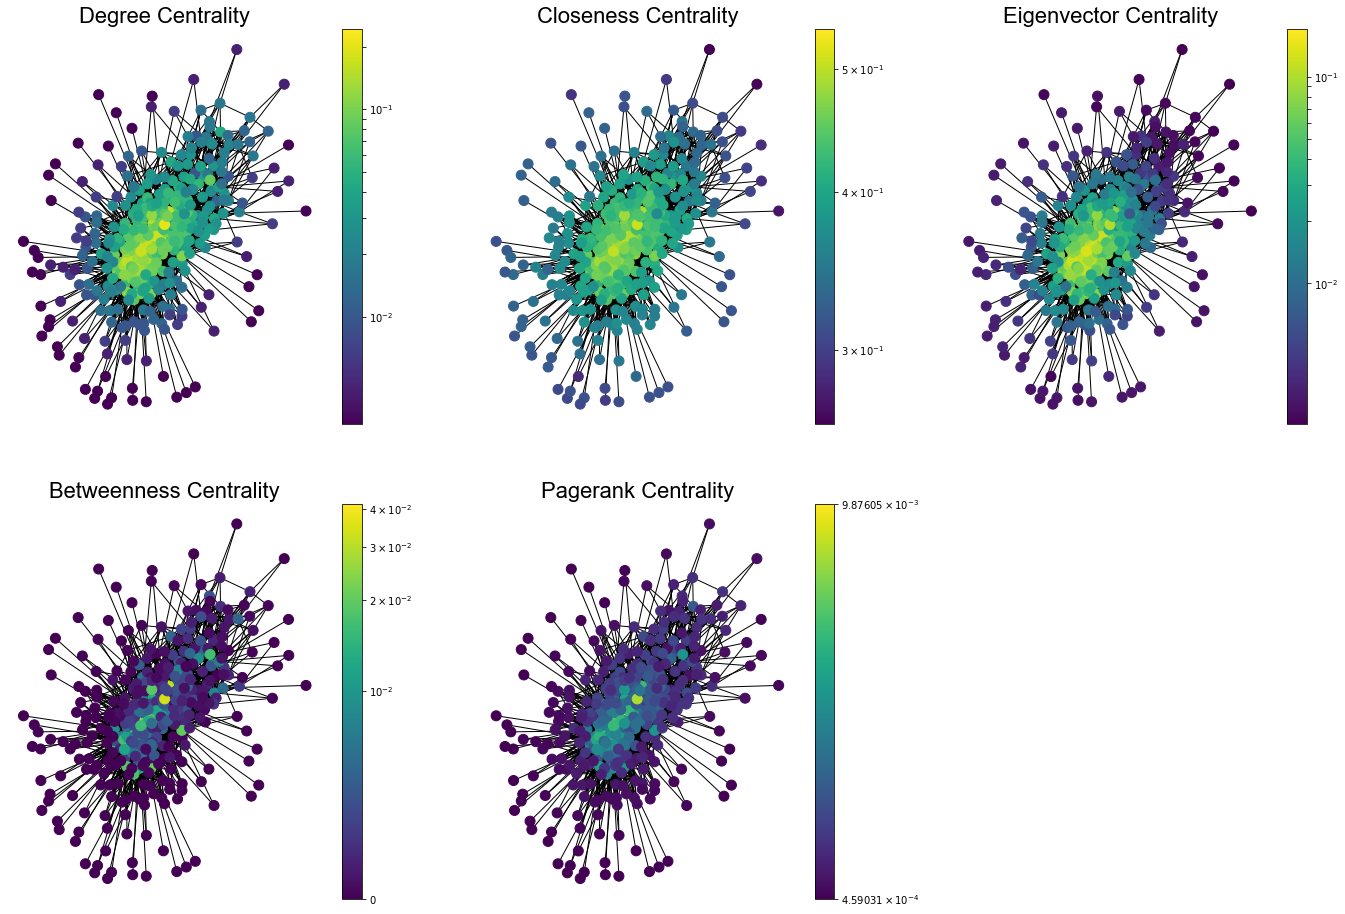

In [28]:
# Function to plot the graphs for each centrality metric
pos = nx.spring_layout(G_2)

matplotlib.rcParams['figure.figsize']= [24, 16]
def draw(G_2, pos, lista, listb, measure_name):
    nodes=nx.draw_networkx_nodes(G_2, pos, node_size=100, cmap=plt.cm.viridis,node_color=lista,nodelist=listb)
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    edges=nx.draw_networkx_edges(G_2, pos)
    plt.title(measure_name, fontsize=22, fontname='Arial')
    plt.colorbar(nodes)
    plt.axis('off')

plt.subplot(2,3,1)
list_pos_values = []
for i in nx.degree_centrality(G_2).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.degree_centrality(G_2).keys():
    list_pos_keys.append(i)
draw(G_2, pos, list_pos_values, list_pos_keys, 'Degree Centrality')

plt.subplot(2,3,2)
list_pos_values=[]
for i in nx.closeness_centrality(G_2).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.closeness_centrality(G_2).keys():
    list_pos_keys.append(i)
draw(G_2, pos, list_pos_values, list_pos_keys, 'Closeness Centrality')

plt.subplot(2,3,3)
list_pos_values=[]
for i in nx.eigenvector_centrality(G_2).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_2).keys():
    list_pos_keys.append(i)
draw(G_2, pos, list_pos_values, list_pos_keys, 'Eigenvector Centrality')

plt.subplot(2,3,4)
list_pos_values=[]
for i in nx.betweenness_centrality(G_2).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_2).keys():
    list_pos_keys.append(i)
draw(G_2, pos, list_pos_values, list_pos_keys, 'Betweenness Centrality')

plt.subplot(2,3,5)
list_pos_values=[]
for i in nx.pagerank(G_2).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_2).keys():
    list_pos_keys.append(i)
draw(G_2, pos, list_pos_values, list_pos_keys, 'Pagerank Centrality')

### Subset the trips data based on individual communities - Community 3

In [29]:
G_3=nx.from_pandas_edgelist(trip3_wk_community3, source='start_station_name', target='end_station_name',edge_attr='trips')

weights = [G_3[u][v]['trips'] for u,v in G_3.edges()]
myInt = 200
weights[:] = [x / myInt for x in weights]

trips = [G_3[u][v]['trips'] for u,v in G_3.edges()]
trips=[float(i) for i in trips]

### Centrality  for Comm 3

In [30]:
degree = nx.degree_centrality(G_3)
closeness_w = nx.closeness_centrality(G_3, distance = 'trips')
betweenness_w = nx.betweenness_centrality(G_3, weight = 'trips')
eigenvector_w = nx.eigenvector_centrality(G_3, weight = 'trips')
pagerank=nx.pagerank(G_3)


# print out various centrality measures
print('\t\t\t\tDeg\tClo\tBet\tEig\tPR')
for n in G_3.nodes():
    print('%s\t\t\t\t%.3f\t%.3f\t%.3f\t%.3f' % (degree[n], closeness_w[n], betweenness_w[n], eigenvector_w[n], 
                                                     pagerank[n]))

				Deg	Clo	Bet	Eig	PR
0.10600706713780919				0.454	0.019	0.049	0.007
0.024734982332155476				0.391	0.000	0.019	0.002
0.10247349823321554				0.446	0.009	0.049	0.006
0.21908127208480566				0.482	0.029	0.253	0.012
0.06713780918727916				0.428	0.003	0.045	0.004
0.14840989399293286				0.459	0.013	0.096	0.008
0.18374558303886926				0.508	0.026	0.148	0.010
0.127208480565371				0.473	0.023	0.076	0.008
0.10600706713780919				0.465	0.008	0.070	0.006
0.13074204946996465				0.471	0.014	0.098	0.007
0.1519434628975265				0.483	0.029	0.087	0.009
0.0812720848056537				0.433	0.013	0.068	0.005
0.13427561837455831				0.466	0.020	0.090	0.008
0.05653710247349823				0.403	0.001	0.026	0.003
0.0353356890459364				0.395	0.001	0.016	0.002
0.16607773851590105				0.477	0.033	0.108	0.010
0.16607773851590105				0.485	0.031	0.104	0.010
0.10247349823321554				0.431	0.013	0.085	0.006
0.10600706713780919				0.451	0.005	0.098	0.006
0.127208480565371				0.469	0.011	0.130	0.007
0.127208480565371				0.467	0.016	0.077	0.00

In [31]:
# Top 10 nodes with the largest values of degree centrality in descending order
dict(Counter(degree).most_common(5))

{'Barrow St & Hudson St': 0.2508833922261484,
 'Lafayette St & E 8 St': 0.24734982332155478,
 'E 10 St & Avenue A': 0.21908127208480566,
 'Christopher St & Greenwich St': 0.21908127208480566,
 'Cooper Square & Astor Pl': 0.1978798586572438}

In [32]:
 #Top 10 nodes with the largest values of closeness centrality in descending order
dict(Counter(closeness_w).most_common(5))

{'Lafayette St & E 8 St': 0.5154826958105647,
 'Great Jones St': 0.5080789946140036,
 'Christopher St & Greenwich St': 0.5008849557522124,
 'Barrow St & Hudson St': 0.4982394366197183,
 'Forsyth St & Broome St': 0.4904679376083189}

In [33]:
 #Top 10 nodes with the largest values of eigenvector centrality in descending order
dict(Counter(eigenvector_w).most_common(5))

{'Lafayette St & E 8 St': 0.2541239300600237,
 'E 10 St & Avenue A': 0.2525351224616499,
 'Greenwich Ave & 8 Ave': 0.1959585174051578,
 'Cooper Square & Astor Pl': 0.18793433189204464,
 'Broadway & E 14 St': 0.18271725814598486}

In [34]:
 #Top 10 nodes with the largest values of betweenness centrality in descending order
dict(Counter(betweenness_w).most_common(5))

{'Barrow St & Hudson St': 0.052070950801536946,
 'Lafayette St & E 8 St': 0.04483058335215013,
 'Allen St & Hester St': 0.03499740026174934,
 'St Marks Pl & 1 Ave': 0.033259808853009165,
 'E 2 St & Avenue B': 0.03093532551881371}

In [35]:
 #Top 10 nodes with the largest values of pagerank centrality in descending order
dict(Counter(pagerank).most_common(5))

{'Barrow St & Hudson St': 0.01436688442246632,
 'Lafayette St & E 8 St': 0.013286435280177379,
 'E 10 St & Avenue A': 0.012043489233947258,
 'Christopher St & Greenwich St': 0.011742013221009085,
 'Greenwich Ave & 8 Ave': 0.01145763689042615}

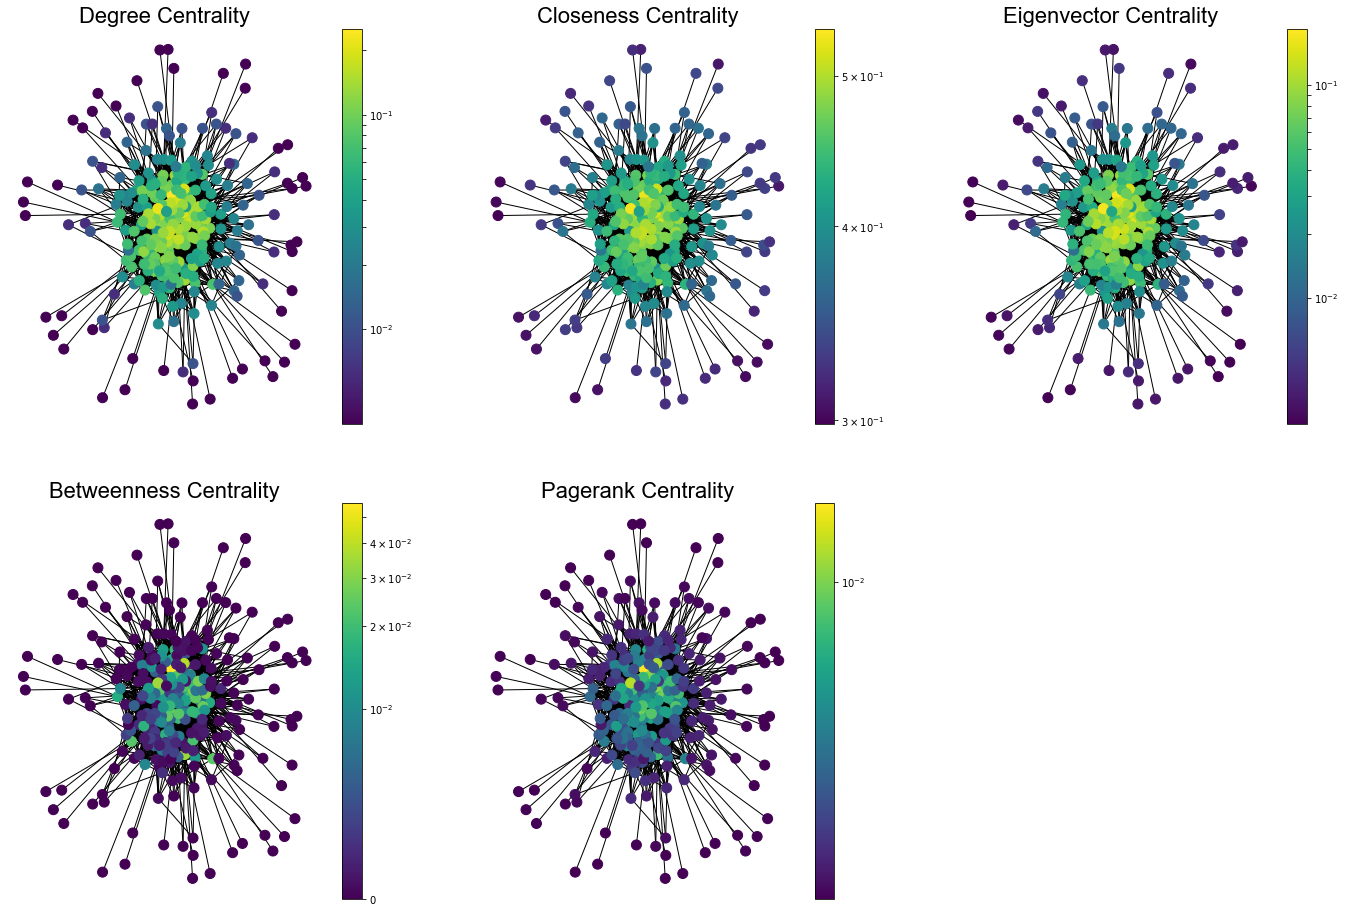

In [36]:
# Function to plot the graphs for each centrality metric
pos = nx.spring_layout(G_3)

matplotlib.rcParams['figure.figsize']= [24, 16]
def draw(G_3, pos, lista, listb, measure_name):
    nodes=nx.draw_networkx_nodes(G_3, pos, node_size=100, cmap=plt.cm.viridis,node_color=lista,nodelist=listb)
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    edges=nx.draw_networkx_edges(G_3, pos)
    plt.title(measure_name, fontsize=22, fontname='Arial')
    plt.colorbar(nodes)
    plt.axis('off')

plt.subplot(2,3,1)
list_pos_values = []
for i in nx.degree_centrality(G_3).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.degree_centrality(G_3).keys():
    list_pos_keys.append(i)
draw(G_3, pos, list_pos_values, list_pos_keys, 'Degree Centrality')

plt.subplot(2,3,2)
list_pos_values=[]
for i in nx.closeness_centrality(G_3).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.closeness_centrality(G_3).keys():
    list_pos_keys.append(i)
draw(G_3, pos, list_pos_values, list_pos_keys, 'Closeness Centrality')

plt.subplot(2,3,3)
list_pos_values=[]
for i in nx.eigenvector_centrality(G_3).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_3).keys():
    list_pos_keys.append(i)
draw(G_3, pos, list_pos_values, list_pos_keys, 'Eigenvector Centrality')

plt.subplot(2,3,4)
list_pos_values=[]
for i in nx.betweenness_centrality(G_3).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_3).keys():
    list_pos_keys.append(i)
draw(G_3, pos, list_pos_values, list_pos_keys, 'Betweenness Centrality')

plt.subplot(2,3,5)
list_pos_values=[]
for i in nx.pagerank(G_3).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_3).keys():
    list_pos_keys.append(i)
draw(G_3, pos, list_pos_values, list_pos_keys, 'Pagerank Centrality')

# Weekend Evening Slot (Sunday) 20:00 - 24:00

In [37]:
time6_wkend = pd.read_csv('Clean_data_files_for_Community/time6_wkend.csv')

In [38]:
trip6_wkend=time6_wkend.groupby(['start_station_name','end_station_name'])['tripduration'].count().reset_index()
trip6_wkend.columns=['start_station_name','end_station_name','trips']

In [39]:
trip6_wkend_latlong_start=time6_wkend.groupby(['start_station_name', 'start_station_latitude', 'start_station_longitude'])['bikeid'].count().reset_index()
trip6_wkend_latlong_start.columns=['station_name','latitude', 'longitude','trips']

In [40]:
trip6_wkend_latlong_end=time6_wkend.groupby(['end_station_name', 'end_station_latitude', 'end_station_longitude'])['bikeid'].count().reset_index()
trip6_wkend_latlong_end.columns=['station_name','latitude', 'longitude','trips']

In [41]:
trip6_wkend_latlong = pd.concat([trip6_wkend_latlong_start, trip6_wkend_latlong_end], axis=0)

In [42]:
G=nx.from_pandas_edgelist(trip6_wkend, source='start_station_name', target='end_station_name',edge_attr='trips')

weights = [G[u][v]['trips'] for u,v in G.edges()]
myInt = 200
weights[:] = [x / myInt for x in weights]

trips = [G[u][v]['trips'] for u,v in G.edges()]
trips=[float(i) for i in trips]

In [43]:
gn_communities = greedy_modularity_communities(G)

In [44]:
gn_dict_communities = {}

for i, c in enumerate(gn_communities):
#     print ("Community {}".format(i))
    for node in c:
        gn_dict_communities[node] = i+1
        
for node in G:
    if node not in gn_dict_communities.keys():
        gn_dict_communities[node] = -1

In [45]:
gn_df=pd.DataFrame(gn_dict_communities.items())
gn_df.columns = ['station_name','Community']
gn_df.head()

,station_name,Community
0,Lefferts Pl & Franklin Ave,1
1,Franklin Ave & Myrtle Ave,1
2,Douglass St & 4 Ave,1
3,Court St & State St,1
4,Van Brunt St & Wolcott St,1


In [46]:
trip6_wkend=pd.merge(trip6_wkend,gn_df,left_on='start_station_name', right_on='station_name')
trip6_wkend=pd.merge(trip6_wkend,gn_df,left_on='end_station_name', right_on='station_name')
trip6_wkend=trip6_wkend.drop(['station_name_x','station_name_y'], axis=1)
trip6_wkend.columns=['start_station_name','end_station_name','trips','start_community','end_community']
trip6_wkend.head()

,start_station_name,end_station_name,trips,start_community,end_community
0,1 Ave & E 16 St,Allen St & Hester St,1,3,3
1,39 St & 2 Ave - Citi Bike HQ at Industry City,Allen St & Hester St,1,3,3
2,Broad St & Bridge St,Allen St & Hester St,1,3,3
3,Centre St & Worth St,Allen St & Hester St,1,3,3
4,E 2 St & Avenue A,Allen St & Hester St,1,3,3


In [47]:
trip6_wkend[trip6_wkend['start_community']==5]

,start_station_name,end_station_name,trips,start_community,end_community
744,2 Ave & E 96 St,2 Ave & E 104 St,3,5,5
746,E 128 St & Madison Ave,2 Ave & E 104 St,1,5,5
747,E 81 St & 3 Ave,2 Ave & E 104 St,1,5,5
748,Lexington Ave & E 127 St,2 Ave & E 104 St,1,5,5
749,2 Ave & E 96 St,2 Ave & E 99 St,1,5,5
750,2 Ave & E 99 St,2 Ave & E 99 St,1,5,5
752,2 Ave & E 96 St,E 97 St & Madison Ave,1,5,2
783,E 81 St & 3 Ave,1 Ave & E 62 St,1,5,2
1547,Lexington Ave & E 127 St,Canal St & Rutgers St,1,5,3
1665,Amsterdam Ave & W 125 St,Frederick Douglass Blvd & W 129 St,1,5,5


In [48]:
trip6_wkend_community1 = trip6_wkend[trip6_wkend['start_community']==1]
trip6_wkend_community2 = trip6_wkend[trip6_wkend['start_community']==2]
trip6_wkend_community3 = trip6_wkend[trip6_wkend['start_community']==3]

### Subset the trips data based on individual communities - Community 1

In [49]:
G_4=nx.from_pandas_edgelist(trip6_wkend_community1, source='start_station_name', target='end_station_name',edge_attr='trips')

weights = [G_4[u][v]['trips'] for u,v in G_4.edges()]
myInt = 200
weights[:] = [x / myInt for x in weights]

trips = [G_4[u][v]['trips'] for u,v in G_4.edges()]
trips=[float(i) for i in trips]

In [50]:
degree = nx.degree_centrality(G_4)
closeness_w = nx.closeness_centrality(G_4, distance = 'trips')
betweenness_w = nx.betweenness_centrality(G_4, weight = 'trips')
eigenvector_w = nx.eigenvector_centrality(G_4, weight = 'trips')
pagerank=nx.pagerank(G_4)


# print out various centrality measures
print('Node\t\t\t\t\tDeg\tClo\tBet\tEig\tPR')
for n in G_4.nodes():
    print('%s\t\t\t\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f' % (n, degree[n], closeness_w[n], betweenness_w[n], eigenvector_w[n], 
                                                     pagerank[n]))

Node					Deg	Clo	Bet	Eig	PR
Lewis Ave & Kosciuszko St				0.013	0.242	0.012	0.023	0.004
E 27 St & 1 Ave				0.003	0.195	0.000	0.003	0.001
Kent Ave & S 11 St				0.007	0.187	0.001	0.020	0.002
Norfolk St & Broome St				0.007	0.203	0.004	0.009	0.002
S 4 St & Rodney St				0.016	0.246	0.020	0.048	0.004
Huron St & Franklin St				0.026	0.263	0.029	0.065	0.006
48 Ave & 30 Pl				0.003	0.209	0.000	0.009	0.001
McGuinness Blvd & Eagle St				0.013	0.196	0.013	0.008	0.004
Center Blvd & 51 Ave				0.003	0.164	0.000	0.001	0.001
1 Pl & Clinton St				0.013	0.207	0.002	0.037	0.002
Clark St & Henry St				0.030	0.257	0.028	0.183	0.006
Congress St & Clinton St				0.013	0.199	0.002	0.048	0.003
Pierrepont St & Monroe Pl				0.007	0.199	0.001	0.021	0.002
Wythe Ave & Metropolitan Ave				0.039	0.271	0.080	0.077	0.009
E 75 St & 3 Ave				0.003	0.213	0.000	0.011	0.001
Atlantic Ave & Fort Greene Pl				0.056	0.304	0.114	0.254	0.012
Hicks St & Montague St				0.023	0.260	0.024	0.093	0.005
Cadman Plaza E & Red Cross Pl				0.

### Centrality 

In [51]:
# Top 10 nodes with the largest values of degree centrality in descending order
dict(Counter(degree).most_common(5))

{'Atlantic Ave & Fort Greene Pl': 0.05592105263157894,
 'Bond St & Fulton St': 0.049342105263157895,
 'Dean St & 4 Ave': 0.042763157894736836,
 'Wythe Ave & Metropolitan Ave': 0.039473684210526314,
 'Bedford Ave & Bergen St': 0.039473684210526314}

In [52]:
 #Top 10 nodes with the largest values of closeness centrality in descending order
dict(Counter(closeness_w).most_common(5))

{'Atlantic Ave & Fort Greene Pl': 0.30430430430430433,
 'Bond St & Fulton St': 0.30158730158730157,
 'Bedford Ave & Bergen St': 0.29174664107485604,
 'Scholes St & Manhattan Ave': 0.28679245283018867,
 'Front St & Gold St': 0.28174235403151066}

In [53]:
 #Top 10 nodes with the largest values of eigenvector centrality in descending order
dict(Counter(eigenvector_w).most_common(5))

{'Bond St & Fulton St': 0.25821140216585436,
 'Atlantic Ave & Fort Greene Pl': 0.2535419606102032,
 'Bergen St & Smith St': 0.2509615293070506,
 'Dean St & 4 Ave': 0.21927560078749503,
 'Jay St & Tech Pl': 0.218022340979565}

In [54]:
 #Top 10 nodes with the largest values of betweenness centrality in descending order
dict(Counter(betweenness_w).most_common(5))

{'Bond St & Fulton St': 0.11581567148722022,
 'Atlantic Ave & Fort Greene Pl': 0.11415313423004486,
 'Bedford Ave & Bergen St': 0.08839925142669268,
 'Wythe Ave & Metropolitan Ave': 0.0795042474295798,
 'Scholes St & Manhattan Ave': 0.07245588144204503}

In [55]:
 #Top 10 nodes with the largest values of pagerank centrality in descending order
dict(Counter(pagerank).most_common(5))

{'Atlantic Ave & Fort Greene Pl': 0.011857207591696325,
 'Bond St & Fulton St': 0.010383361820583949,
 'Wythe Ave & Metropolitan Ave': 0.009073499524805878,
 'Dean St & 4 Ave': 0.009050720040093711,
 'Bedford Ave & Bergen St': 0.008386392493350587}

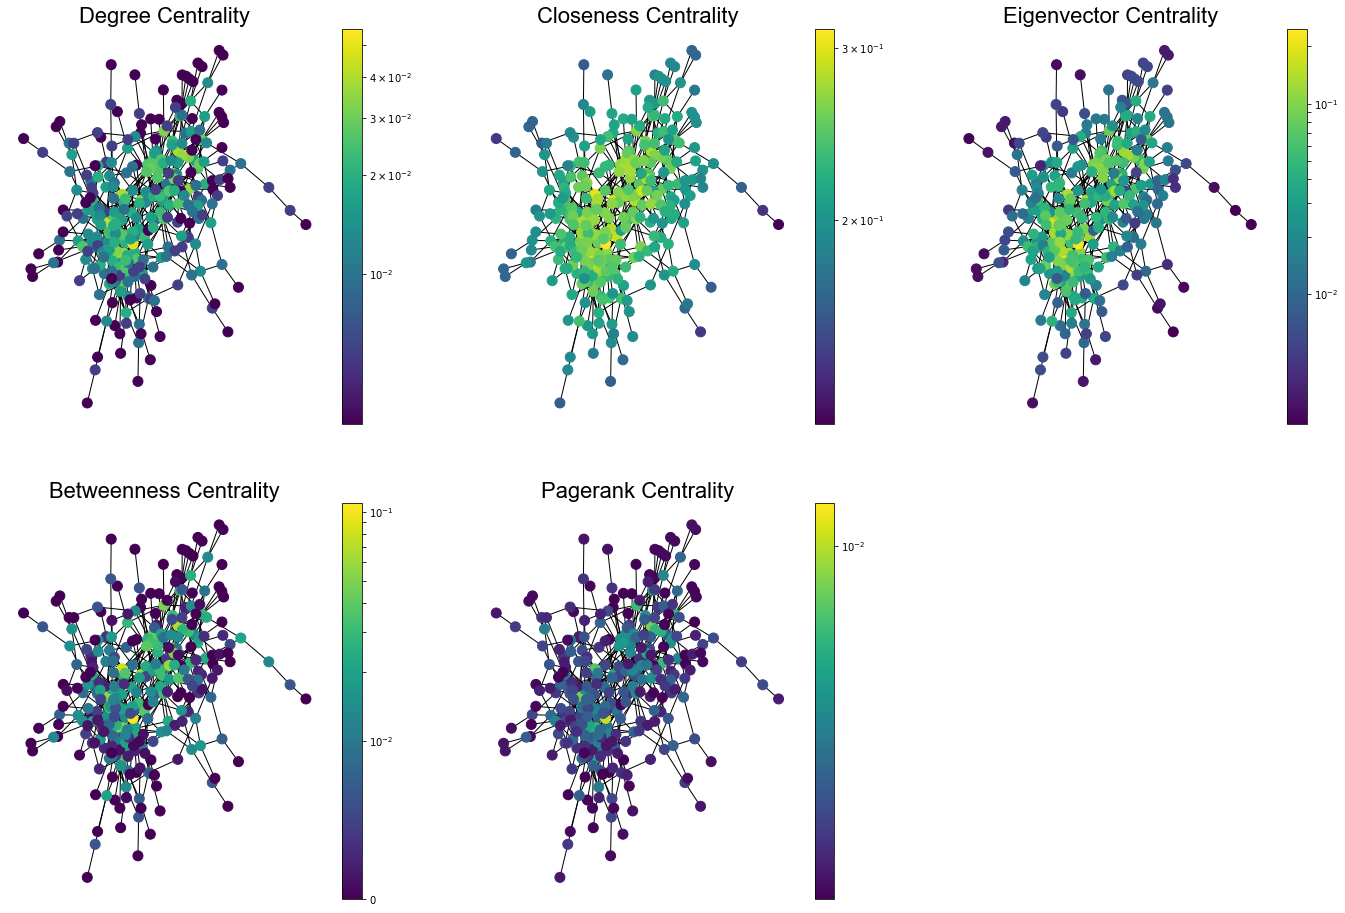

In [56]:
# Function to plot the graphs for each centrality metric
pos = nx.spring_layout(G_4)

matplotlib.rcParams['figure.figsize']= [24, 16]
def draw(G_4, pos, lista, listb, measure_name):
    nodes=nx.draw_networkx_nodes(G_4, pos, node_size=100, cmap=plt.cm.viridis,node_color=lista,nodelist=listb)
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    edges=nx.draw_networkx_edges(G_4, pos)
    plt.title(measure_name, fontsize=22, fontname='Arial')
    plt.colorbar(nodes)
    plt.axis('off')

plt.subplot(2,3,1)
list_pos_values = []
for i in nx.degree_centrality(G_4).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.degree_centrality(G_4).keys():
    list_pos_keys.append(i)
draw(G_4, pos, list_pos_values, list_pos_keys, 'Degree Centrality')

plt.subplot(2,3,2)
list_pos_values=[]
for i in nx.closeness_centrality(G_4).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.closeness_centrality(G_4).keys():
    list_pos_keys.append(i)
draw(G_4, pos, list_pos_values, list_pos_keys, 'Closeness Centrality')

plt.subplot(2,3,3)
list_pos_values=[]
for i in nx.eigenvector_centrality(G_4).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_4).keys():
    list_pos_keys.append(i)
draw(G_4, pos, list_pos_values, list_pos_keys, 'Eigenvector Centrality')

plt.subplot(2,3,4)
list_pos_values=[]
for i in nx.betweenness_centrality(G_4).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_4).keys():
    list_pos_keys.append(i)
draw(G_4, pos, list_pos_values, list_pos_keys, 'Betweenness Centrality')

plt.subplot(2,3,5)
list_pos_values=[]
for i in nx.pagerank(G_4).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_4).keys():
    list_pos_keys.append(i)
draw(G_4, pos, list_pos_values, list_pos_keys, 'Pagerank Centrality')

### Subset the trips data based on individual communities - Community 2

In [57]:
G_5=nx.from_pandas_edgelist(trip6_wkend_community2, source='start_station_name', target='end_station_name',edge_attr='trips')

weights = [G_5[u][v]['trips'] for u,v in G_5.edges()]
myInt = 200
weights[:] = [x / myInt for x in weights]

trips = [G_5[u][v]['trips'] for u,v in G_5.edges()]
trips=[float(i) for i in trips]

### Centrality 

In [58]:
degree = nx.degree_centrality(G_5)
closeness_w = nx.closeness_centrality(G_5, distance = 'trips')
betweenness_w = nx.betweenness_centrality(G_5, weight = 'trips')
eigenvector_w = nx.eigenvector_centrality(G_5, weight = 'trips')
pagerank=nx.pagerank(G_5)


# print out various centrality measures
print('Node\t\t\t\t\tDeg\tClo\tBet\tEig\tPR')
for n in G_5.nodes():
    print('%s\t\t\t\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f' % (n, degree[n], closeness_w[n], betweenness_w[n], eigenvector_w[n], 
                                                     pagerank[n]))

Node					Deg	Clo	Bet	Eig	PR
W 20 St & 11 Ave				0.080	0.365	0.061	0.129	0.011
Allen St & Hester St				0.003	0.267	0.000	0.008	0.001
E 25 St & 2 Ave				0.077	0.334	0.044	0.128	0.011
Allen St & Rivington St				0.006	0.270	0.000	0.014	0.001
E 32 St & Park Ave				0.040	0.339	0.012	0.082	0.005
W 21 St & 6 Ave				0.087	0.362	0.031	0.191	0.010
E 11 St & 2 Ave				0.012	0.293	0.003	0.028	0.002
W 26 St & 10 Ave				0.022	0.315	0.006	0.039	0.003
W 31 St & 7 Ave				0.053	0.320	0.013	0.188	0.007
West End Ave & W 94 St				0.015	0.280	0.004	0.006	0.003
E 30 St & Park Ave S				0.028	0.328	0.004	0.069	0.004
E 15 St & 3 Ave				0.012	0.278	0.001	0.032	0.002
E 55 St & 2 Ave				0.050	0.346	0.022	0.077	0.006
Lexington Ave & E 26 St				0.059	0.331	0.026	0.133	0.008
W 100 St & Broadway				0.031	0.289	0.015	0.009	0.005
1 Ave & E 30 St				0.046	0.344	0.016	0.111	0.006
E 19 St & 3 Ave				0.009	0.271	0.000	0.014	0.002
Broadway & W 29 St				0.031	0.300	0.007	0.041	0.004
W 27 St & 7 Ave				0.037	0.325	0.018	0.065	0.

In [59]:
# Top 10 nodes with the largest values of degree centrality in descending order
dict(Counter(degree).most_common(5))

{'9 Ave & W 45 St': 0.09287925696594428,
 'W 21 St & 6 Ave': 0.08668730650154799,
 'Pershing Square North': 0.08668730650154799,
 'W 20 St & 11 Ave': 0.0804953560371517,
 'Broadway & W 60 St': 0.0804953560371517}

In [60]:
 #Top 10 nodes with the largest values of closeness centrality in descending order
dict(Counter(closeness_w).most_common(5))

{'9 Ave & W 45 St': 0.37689614935822635,
 'Pershing Square North': 0.3687214611872146,
 'W 20 St & 11 Ave': 0.36455981941309257,
 'E 31 St & 3 Ave': 0.3641488162344983,
 'Broadway & W 60 St': 0.36332958380202474}

In [61]:
 #Top 10 nodes with the largest values of eigenvector centrality in descending order
dict(Counter(eigenvector_w).most_common(5))

{'8 Ave & W 31 St': 0.19734562086135082,
 'W 21 St & 6 Ave': 0.19118873533945394,
 'W 31 St & 7 Ave': 0.18826667654331564,
 'E 56 St & 3 Ave': 0.18423354308325451,
 'Pershing Square North': 0.18240325810237418}

In [62]:
 #Top 10 nodes with the largest values of betweenness centrality in descending order
dict(Counter(betweenness_w).most_common(5))

{'9 Ave & W 45 St': 0.06430900020451699,
 'W 20 St & 11 Ave': 0.06095290800182057,
 'Pershing Square North': 0.056465885922151036,
 '1 Ave & E 68 St': 0.0548923530729927,
 'Broadway & E 22 St': 0.05090558687181571}

In [63]:
 #Top 10 nodes with the largest values of pagerank centrality in descending order
dict(Counter(pagerank).most_common(5))

{'W 20 St & 11 Ave': 0.011318864840637563,
 'E 25 St & 2 Ave': 0.011310664958778964,
 'Pershing Square North': 0.0111452493443464,
 '9 Ave & W 45 St': 0.010794175336461397,
 'Broadway & E 22 St': 0.010306359026404314}

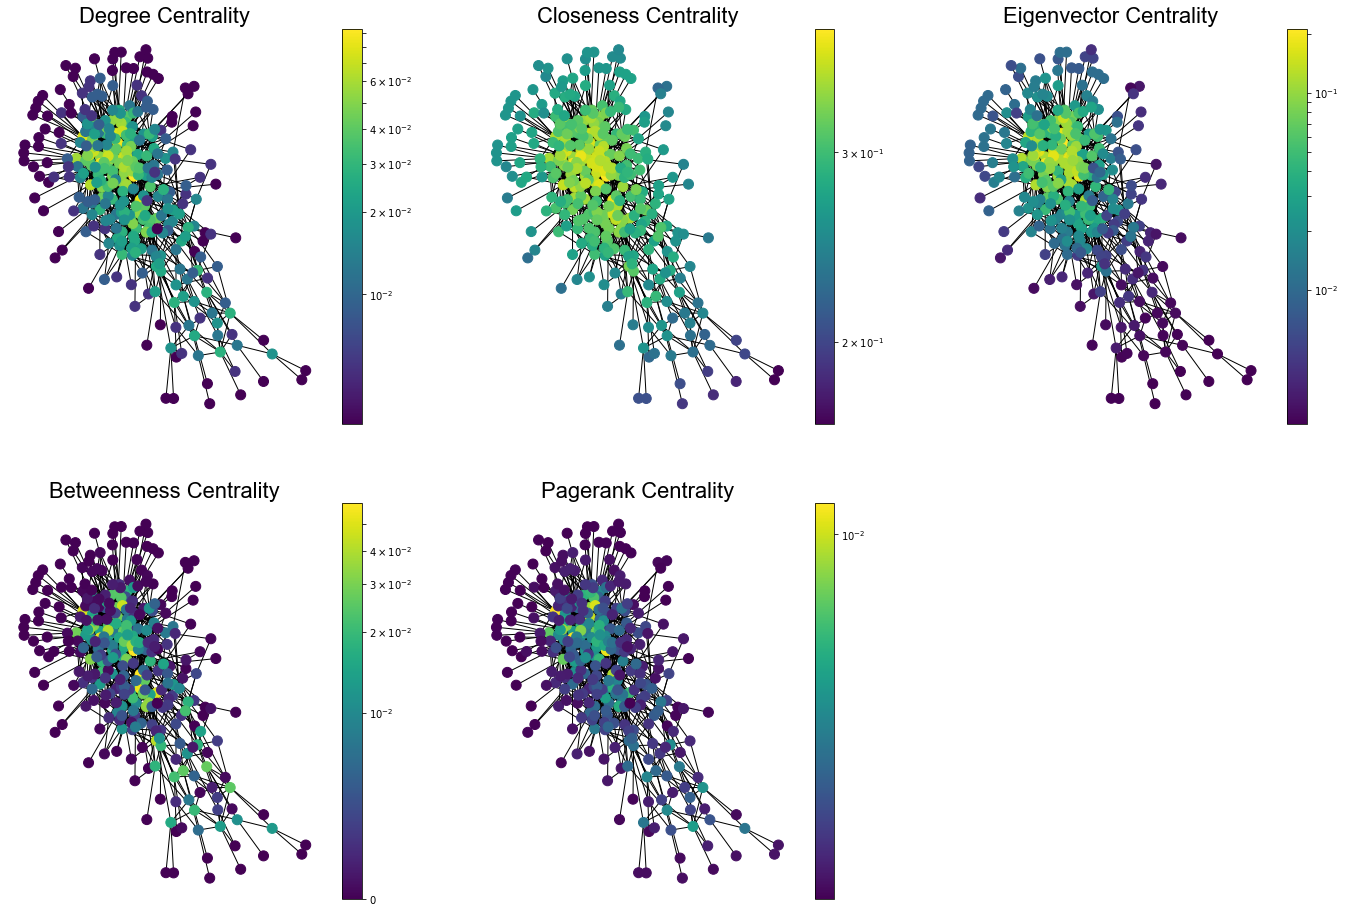

In [64]:
# Function to plot the graphs for each centrality metric
pos = nx.spring_layout(G_5)

matplotlib.rcParams['figure.figsize']= [24, 16]
def draw(G_5, pos, lista, listb, measure_name):
    nodes=nx.draw_networkx_nodes(G_5, pos, node_size=100, cmap=plt.cm.viridis,node_color=lista,nodelist=listb)
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    edges=nx.draw_networkx_edges(G_5, pos)
    plt.title(measure_name, fontsize=22, fontname='Arial')
    plt.colorbar(nodes)
    plt.axis('off')

plt.subplot(2,3,1)
list_pos_values = []
for i in nx.degree_centrality(G_5).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.degree_centrality(G_5).keys():
    list_pos_keys.append(i)
draw(G_5, pos, list_pos_values, list_pos_keys, 'Degree Centrality')

plt.subplot(2,3,2)
list_pos_values=[]
for i in nx.closeness_centrality(G_5).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.closeness_centrality(G_5).keys():
    list_pos_keys.append(i)
draw(G_5, pos, list_pos_values, list_pos_keys, 'Closeness Centrality')

plt.subplot(2,3,3)
list_pos_values=[]
for i in nx.eigenvector_centrality(G_5).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_5).keys():
    list_pos_keys.append(i)
draw(G_5, pos, list_pos_values, list_pos_keys, 'Eigenvector Centrality')

plt.subplot(2,3,4)
list_pos_values=[]
for i in nx.betweenness_centrality(G_5).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_5).keys():
    list_pos_keys.append(i)
draw(G_5, pos, list_pos_values, list_pos_keys, 'Betweenness Centrality')

plt.subplot(2,3,5)
list_pos_values=[]
for i in nx.pagerank(G_5).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_5).keys():
    list_pos_keys.append(i)
draw(G_5, pos, list_pos_values, list_pos_keys, 'Pagerank Centrality')

### Subset the trips data based on individual communities - Community 3

In [65]:
G_6=nx.from_pandas_edgelist(trip6_wkend_community3, source='start_station_name', target='end_station_name',edge_attr='trips')

weights = [G_6[u][v]['trips'] for u,v in G_6.edges()]
myInt = 200
weights[:] = [x / myInt for x in weights]

trips = [G_6[u][v]['trips'] for u,v in G_6.edges()]
trips=[float(i) for i in trips]

### Centrality 

In [66]:
degree = nx.degree_centrality(G_6)
closeness_w = nx.closeness_centrality(G_6, distance = 'trips')
betweenness_w = nx.betweenness_centrality(G_6, weight = 'trips')
eigenvector_w = nx.eigenvector_centrality(G_6, weight = 'trips')
pagerank=nx.pagerank(G_6)


# print out various centrality measures
print('Node\t\t\t\t\tDeg\tClo\tBet\tEig\tPR')
for n in G_6.nodes():
    print('%s\t\t\t\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f' % (n, degree[n], closeness_w[n], betweenness_w[n], eigenvector_w[n], 
                                                     pagerank[n]))

Node					Deg	Clo	Bet	Eig	PR
1 Ave & E 16 St				0.071	0.381	0.011	0.105	0.008
Allen St & Hester St				0.082	0.389	0.037	0.089	0.010
39 St & 2 Ave - Citi Bike HQ at Industry City				0.004	0.281	0.000	0.005	0.001
Broad St & Bridge St				0.016	0.308	0.003	0.009	0.002
Centre St & Worth St				0.016	0.320	0.002	0.010	0.002
E 2 St & Avenue A				0.098	0.407	0.034	0.138	0.011
Forsyth St & Canal St				0.047	0.379	0.020	0.049	0.006
Lexington Ave & E 29 St				0.047	0.367	0.021	0.055	0.006
Mott St & Prince St				0.078	0.381	0.022	0.149	0.009
Rivington St & Chrystie St				0.039	0.365	0.005	0.067	0.004
Stanton St & Chrystie St				0.067	0.359	0.013	0.101	0.007
Allen St & Rivington St				0.090	0.410	0.036	0.122	0.010
1 Ave & E 5 St				0.024	0.352	0.003	0.036	0.003
Clinton St & Grand St				0.071	0.373	0.017	0.105	0.008
Division St & Bowery (old)				0.063	0.365	0.036	0.055	0.009
E 10 St & Avenue A				0.071	0.390	0.013	0.129	0.007
E 11 St & 2 Ave				0.106	0.419	0.033	0.154	0.011
E 11 St & Avenue B				0.071

In [67]:
# Top 10 nodes with the largest values of degree centrality in descending order
dict(Counter(degree).most_common(5))

{'Broadway & E 14 St': 0.13725490196078433,
 'St Marks Pl & 1 Ave': 0.12941176470588234,
 'W 4 St & 7 Ave S': 0.11764705882352941,
 'Lafayette St & E 8 St': 0.11372549019607843,
 'E 13 St & Avenue A': 0.10980392156862745}

In [68]:
 #Top 10 nodes with the largest values of closeness centrality in descending order
dict(Counter(closeness_w).most_common(5))

{'St Marks Pl & 1 Ave': 0.4366438356164384,
 'Broadway & E 14 St': 0.4292929292929293,
 'E 11 St & 2 Ave': 0.4187192118226601,
 'E 11 St & 1 Ave': 0.4166666666666667,
 'E 13 St & Avenue A': 0.4153094462540717}

In [69]:
 #Top 10 nodes with the largest values of eigenvector centrality in descending order
dict(Counter(eigenvector_w).most_common(5))

{'Broadway & E 14 St': 0.22173665530989076,
 'St Marks Pl & 1 Ave': 0.20823522119676147,
 'E 4 St & 2 Ave': 0.2050081034319651,
 'W 4 St & 7 Ave S': 0.19471873609059046,
 'E 11 St & 1 Ave': 0.19457686768307195}

In [70]:
 #Top 10 nodes with the largest values of betweenness centrality in descending order
dict(Counter(betweenness_w).most_common(5))

{'Broadway & E 14 St': 0.06776740024208781,
 'Sullivan St & Washington Sq': 0.05201022258142123,
 'St Marks Pl & 1 Ave': 0.04977428018503301,
 'E 13 St & Avenue A': 0.042214386659391825,
 'E 9 St & Avenue C': 0.041282024865644404}

In [71]:
 #Top 10 nodes with the largest values of pagerank centrality in descending order
dict(Counter(pagerank).most_common(5))

{'Broadway & E 14 St': 0.01574906790303744,
 'W 4 St & 7 Ave S': 0.013177893210655225,
 'St Marks Pl & 1 Ave': 0.012931415749152592,
 'Lafayette St & E 8 St': 0.012155918310431732,
 'E 13 St & Avenue A': 0.011679164909982645}

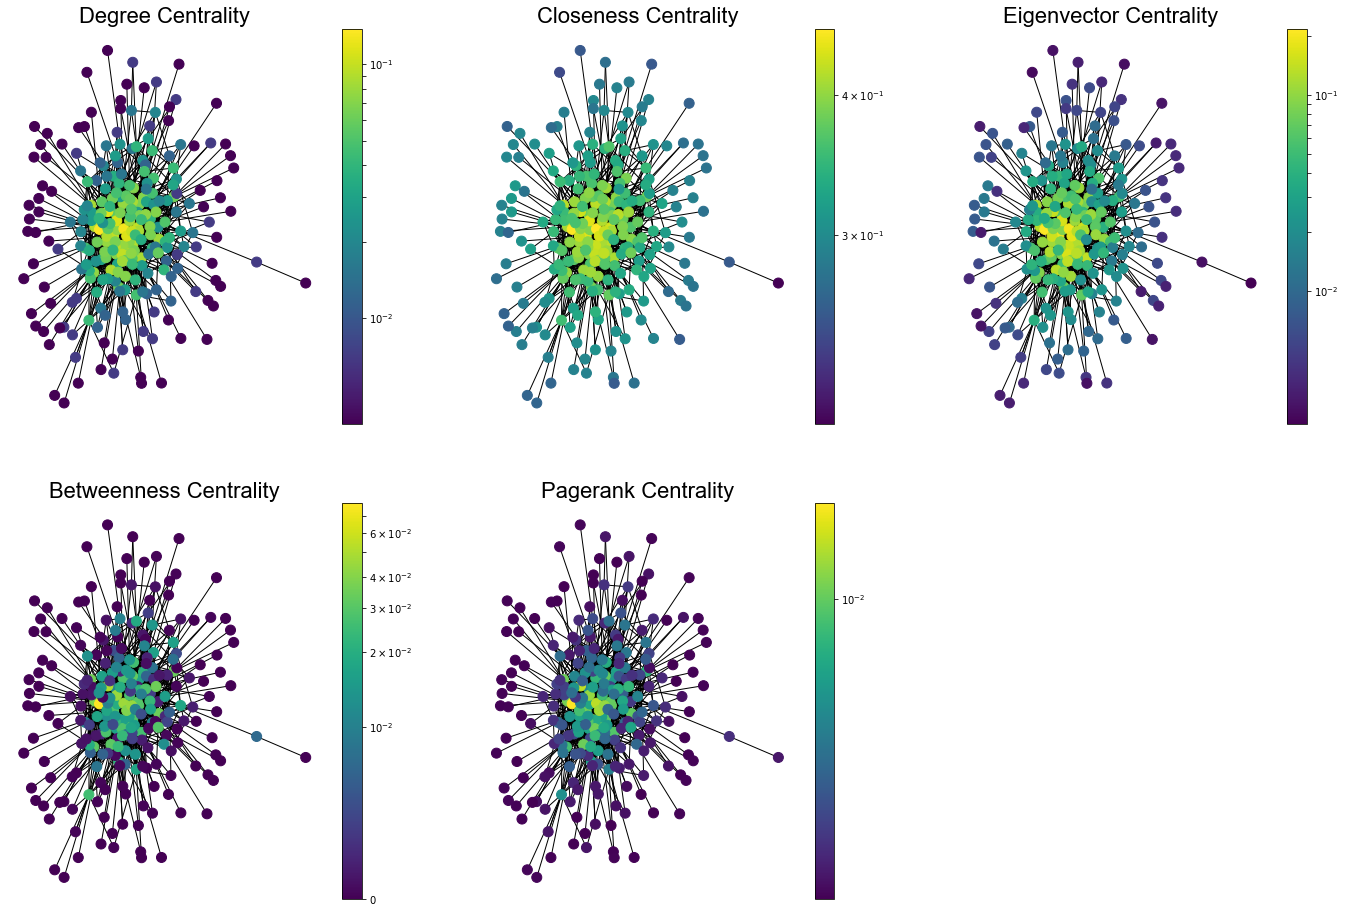

In [72]:
# Function to plot the graphs for each centrality metric
pos = nx.spring_layout(G_6)

matplotlib.rcParams['figure.figsize']= [24, 16]
def draw(G_6, pos, lista, listb, measure_name):
    nodes=nx.draw_networkx_nodes(G_6, pos, node_size=100, cmap=plt.cm.viridis,node_color=lista,nodelist=listb)
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    edges=nx.draw_networkx_edges(G_6, pos)
    plt.title(measure_name, fontsize=22, fontname='Arial')
    plt.colorbar(nodes)
    plt.axis('off')

plt.subplot(2,3,1)
list_pos_values = []
for i in nx.degree_centrality(G_6).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.degree_centrality(G_6).keys():
    list_pos_keys.append(i)
draw(G_6, pos, list_pos_values, list_pos_keys, 'Degree Centrality')

plt.subplot(2,3,2)
list_pos_values=[]
for i in nx.closeness_centrality(G_6).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.closeness_centrality(G_6).keys():
    list_pos_keys.append(i)
draw(G_6, pos, list_pos_values, list_pos_keys, 'Closeness Centrality')

plt.subplot(2,3,3)
list_pos_values=[]
for i in nx.eigenvector_centrality(G_6).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_6).keys():
    list_pos_keys.append(i)
draw(G_6, pos, list_pos_values, list_pos_keys, 'Eigenvector Centrality')

plt.subplot(2,3,4)
list_pos_values=[]
for i in nx.betweenness_centrality(G_6).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_6).keys():
    list_pos_keys.append(i)
draw(G_6, pos, list_pos_values, list_pos_keys, 'Betweenness Centrality')

plt.subplot(2,3,5)
list_pos_values=[]
for i in nx.pagerank(G_6).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G_6).keys():
    list_pos_keys.append(i)
draw(G_6, pos, list_pos_values, list_pos_keys, 'Pagerank Centrality')